# 0.0 IMPORTS

In [2]:
import math
import random
import pickle
import warnings
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb


from scipy                 import stats as ss
from tabulate              import tabulate
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML

from boruta                import BorutaPy
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [3]:
def cramer_v( x, y):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr =max(0, chi2 - ( k-1) * (r-1) / (n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( ( chi2corr/n ) / (min( kcorr-1, rcorr-1 ) ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse}, index=[0] )

def cross_validation( x_trainning, kfold, model_name, model, verbose=False ):

    mae_list= []
    mape_list= []
    rmse_list= []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k * 6 * 7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1) * 6 * 7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining= training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation= validation.drop( ['date', 'sales'], axis=1)
        yvalidation= validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation)

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        #storing performance of each kfold iteration 
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )


    return pd.DataFrame( {'Model Name':model_name,
                         'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                         'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                         'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [5]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge 
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 PASSO 01 - DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.1 Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [8]:
print( 'Number of Rows: {}.'.format( df1.shape[0] ) )
print( 'Number of Cols: {}.'.format( df1.shape[1] ) )

Number of Rows: 1017209.
Number of Cols: 18.


## 1.3 Data Types

In [9]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month  
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) 
                                                                               else x['competition_open_since_month'], axis=1 )
#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) 
                                                                               else x['competition_open_since_year'], axis=1 )                 
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) 
                                                                else x['promo2_since_week'], axis=1)
#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) 
                                                                else x['promo2_since_year'], axis=1)                 
#promo_interval                  
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 
                                                            else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1)

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [15]:
# Central Tendence - mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply(np.median) ).T

# Dispersion - std, var, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.var ) ).T
d3 = pd.DataFrame( num_attributes.apply( min ) ).T
d4 = pd.DataFrame( num_attributes.apply( max ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d7 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d3, d4, d5 , ct1, ct2, d1, d2, d6, d7] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','var','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,var,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,1.036251e+05,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,3.989567e+00,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,1.482192e+07,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,2.156780e+05,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,1.410296e-01,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,2.359612e-01,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.467320e-01,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,1.574434e+08,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,1.096328e+01,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,3.042174e+01,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

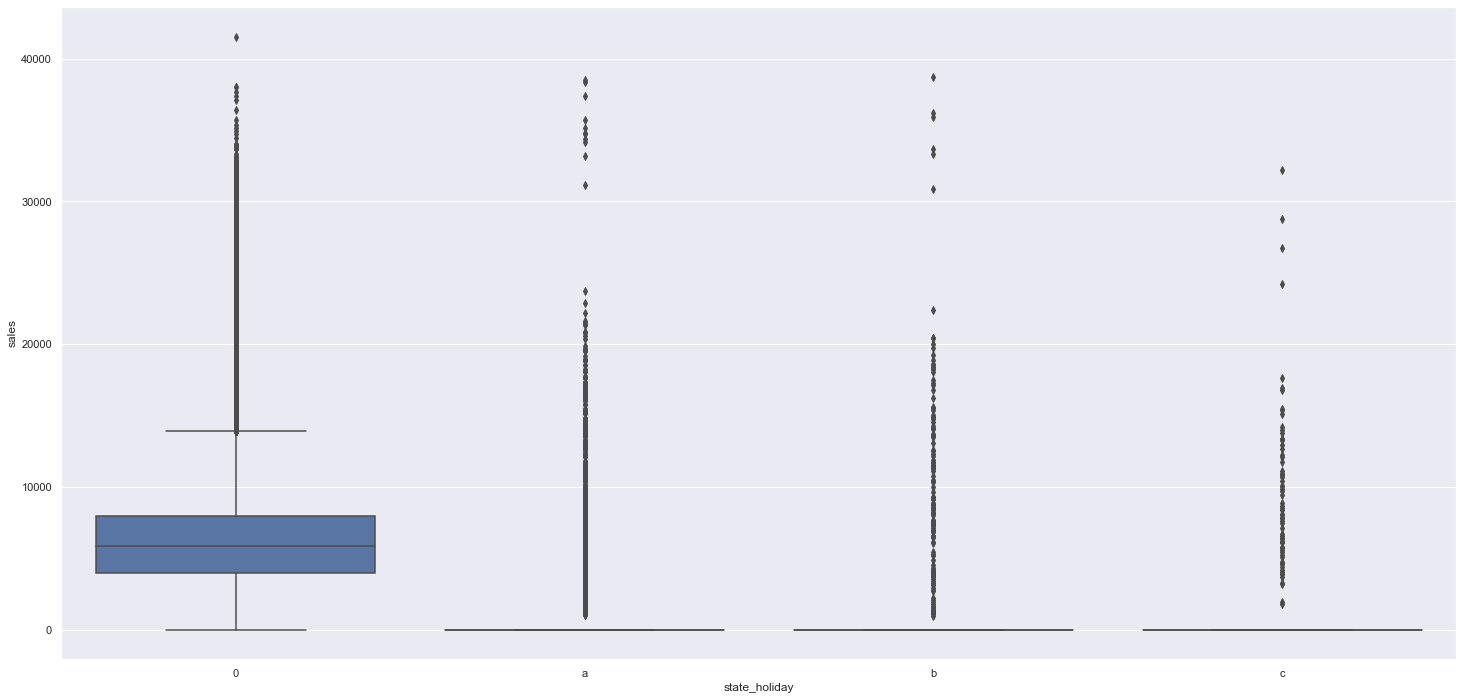

In [17]:
# aqui temos as vendas distribuidas por todas as variaveis a coluna state_holiday, onde 0 representa dias
# sem vendas, o que tem deixado a visualizacao ruim, pois, temos muito mais dias sem feriado do que com
sns.boxplot( x='state_holiday' , y='sales', data=df1 )

<AxesSubplot:xlabel='assortment', ylabel='sales'>

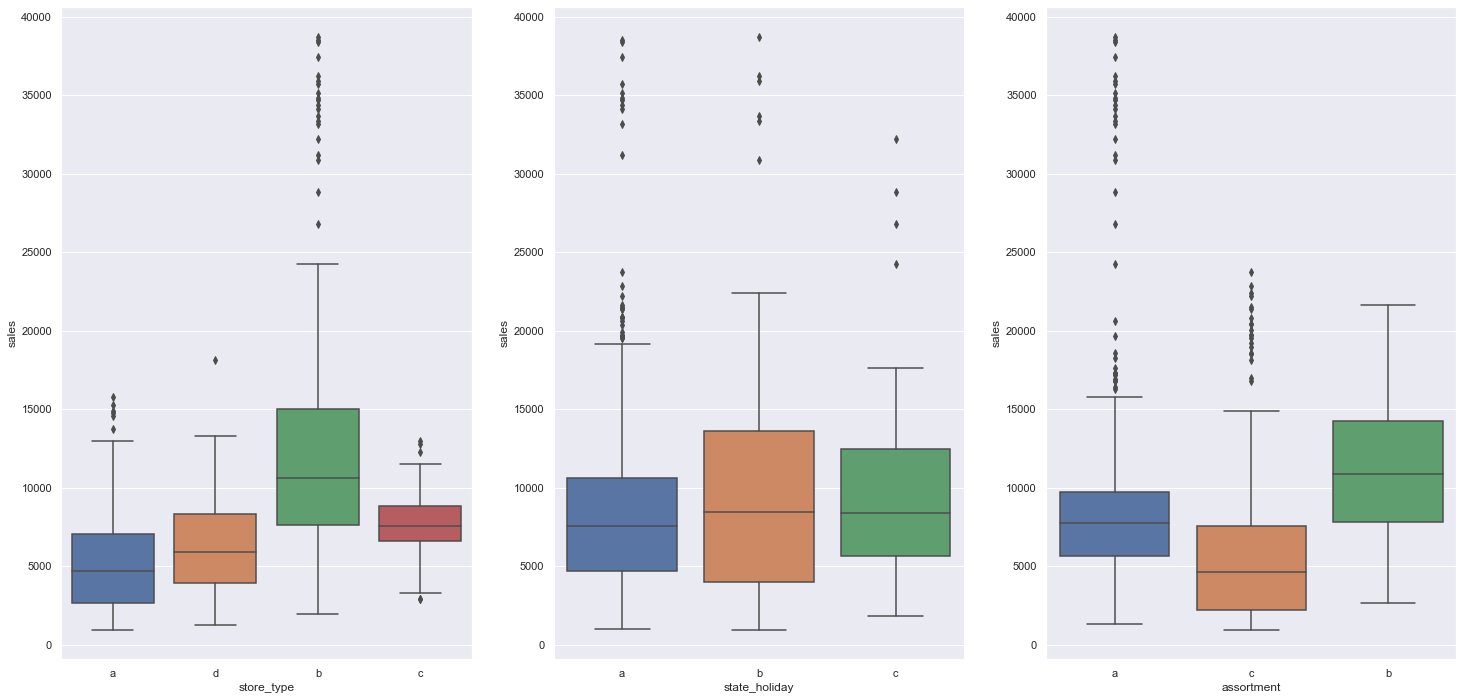

In [18]:
# dado o problema acima, decidi filtrar apenas pelos dias que tiveram feriado e vendas maior do que 0 para analisar
# a distribuicao das vendas em feriados
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='store_type' , y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='state_holiday' , y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment' , y='sales', data=aux1 )

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

### MindMap Hypothesis

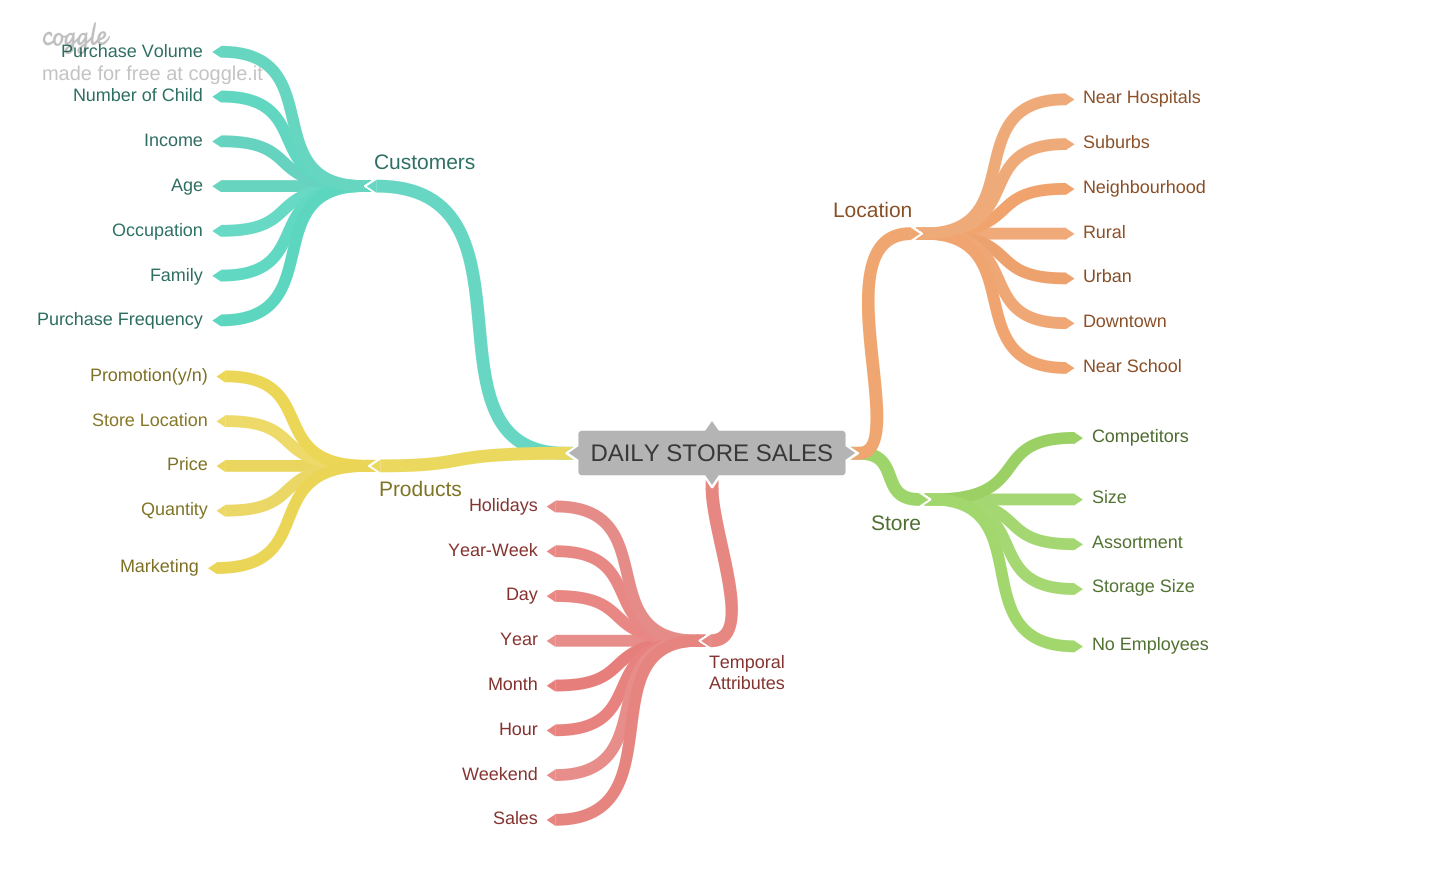

In [20]:
Image('img/mindmaphypothesis.png')

## 2.1. Creating Hypothesis

### 2.1.1. Store Hypothesis

**1.** Lojas com número maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2. Products Hypothesis

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Temporal Hypothesis (Seasonality)

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Final Hypothesis List (Prioritized)

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year-week'] = df2['date'].dt.strftime( '%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'] , month=x['competition_open_since_month'], day=1), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( (df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b'  else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b'  else 'christmas' if x == 'c' else 'regular_day')


# 3.0. PASSO 03 - VARIABLES SELECTION

In [22]:
df3 = df2.copy()

## 3.1. Rows Selection

In [23]:
df3 = df3[( df3['open'] != 0 ) &  ( df3['sales'] > 0 )]

## 3.2. Columns Selection

In [24]:
cols_drop = ['customers', 'open', 'promo_interval','month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [25]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year-week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0. PASSO 04 - EXPLORATORY DATA ANALYSIS (EDA)

In [26]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

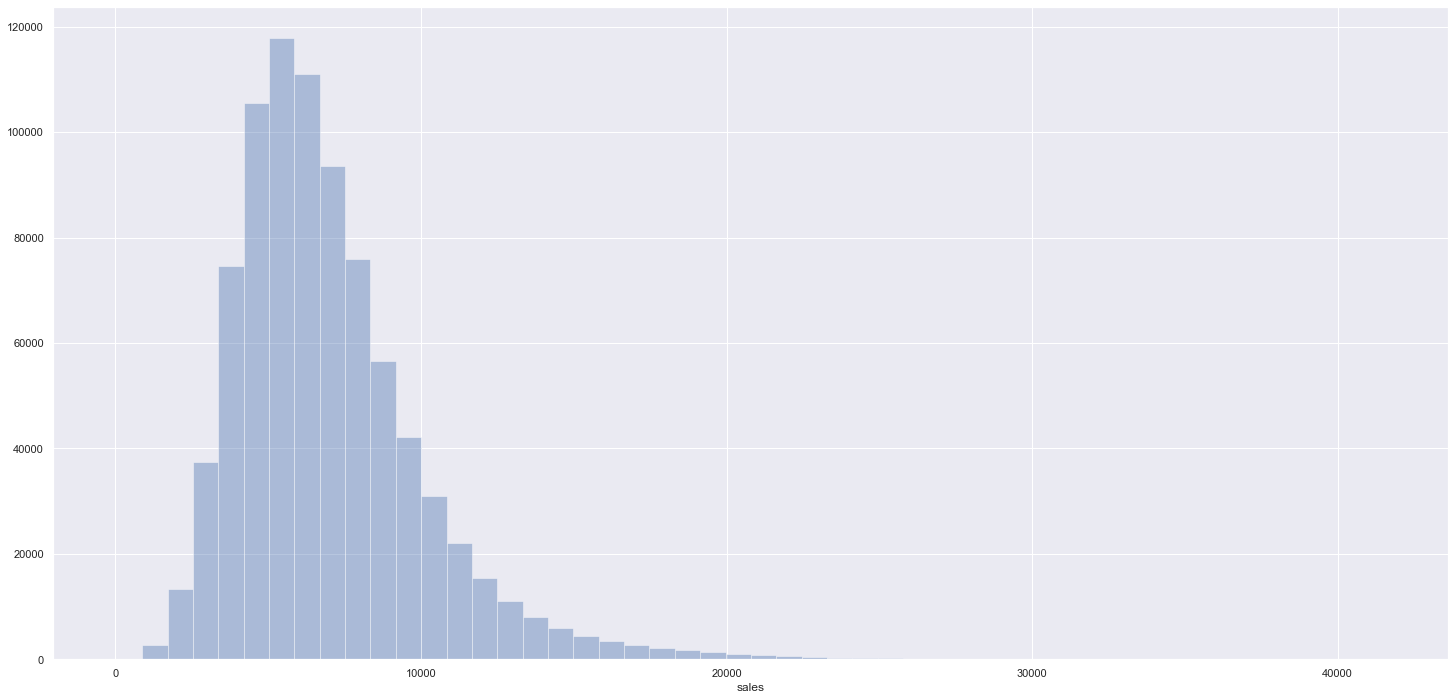

In [27]:
sns.distplot( df4['sales'], kde=False );

### 4.1.2. Numerical Variables

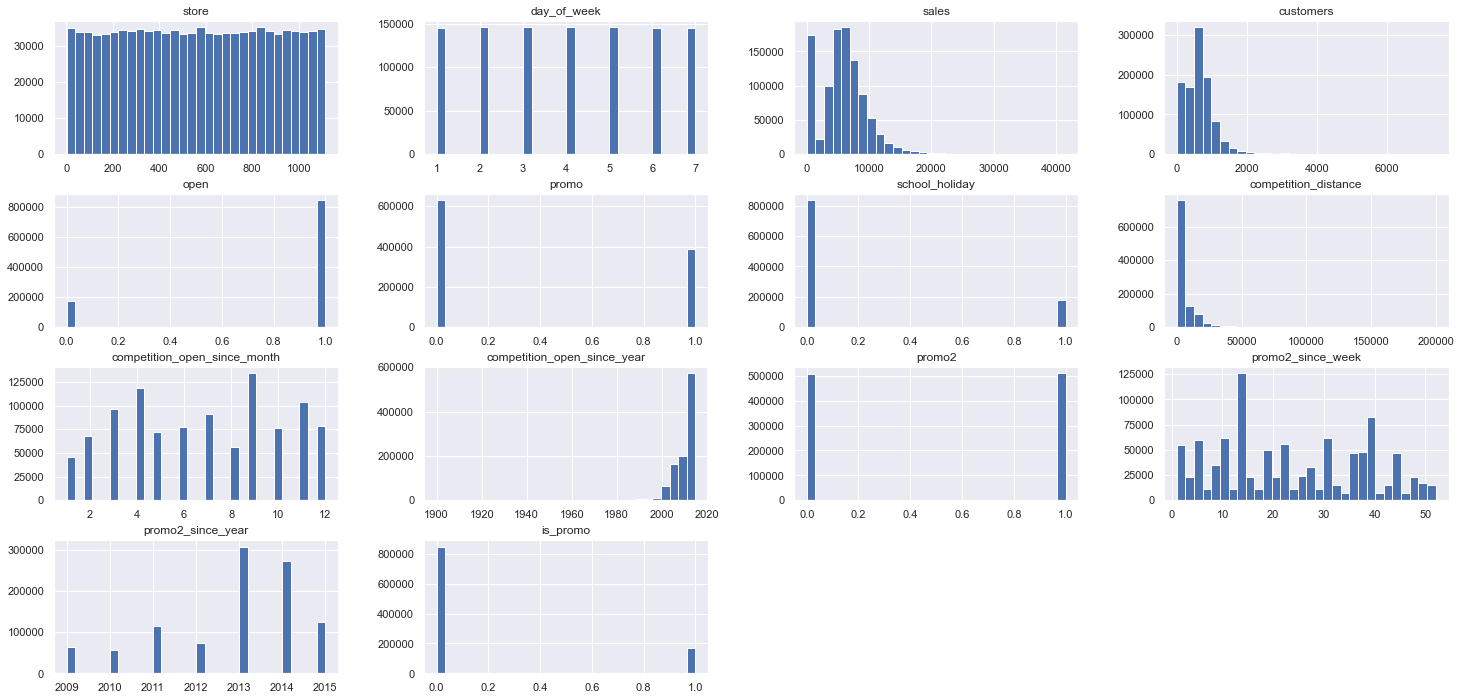

In [28]:
num_attributes.hist(bins=30);

#### 4.1.3. Categorical Variables

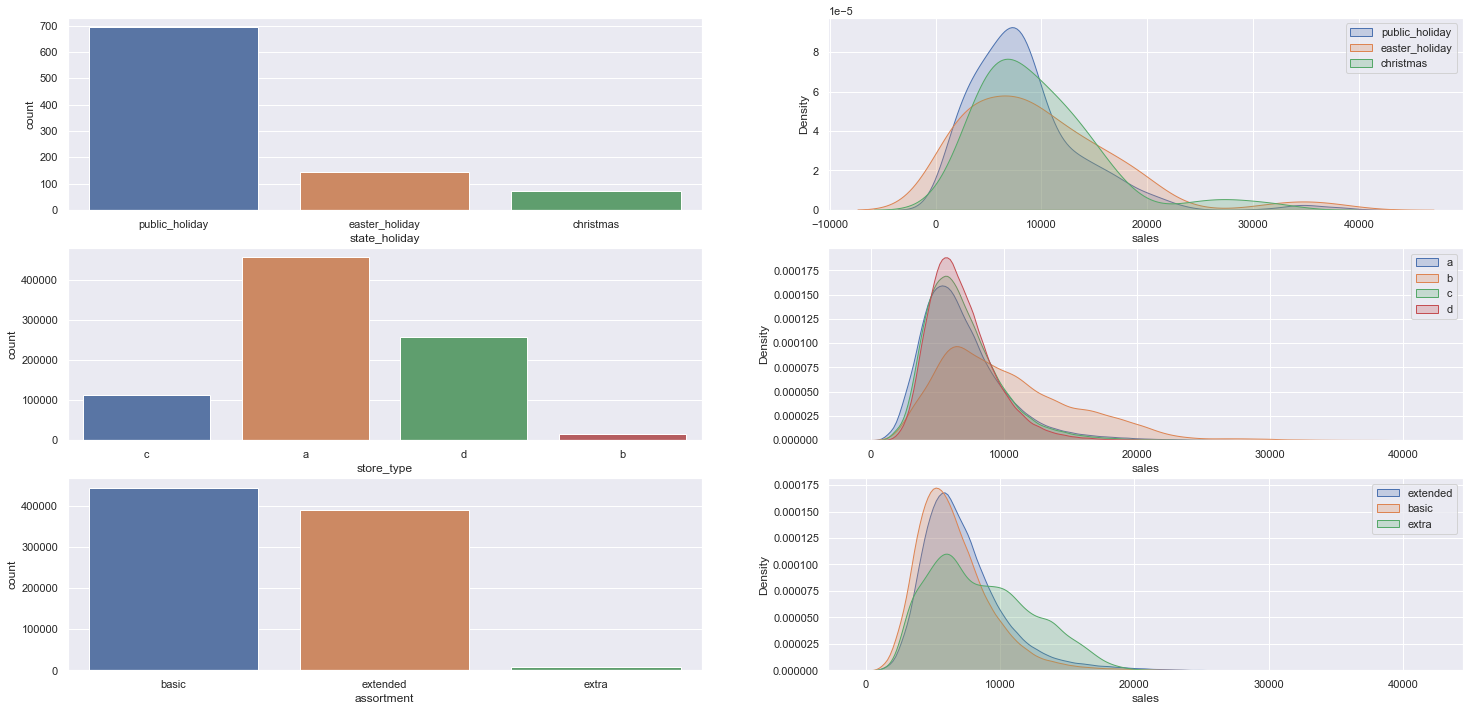

In [29]:
# state_holiday
plt.subplot( 3, 2, 1 );
a = df4[df4['state_holiday'] != 'regular_day'];
sns.countplot( a['state_holiday']);

plt.subplot( 3, 2, 2 );
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True );
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True );
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True );
plt.legend();

# store_type
plt.subplot( 3, 2, 3 );
sns.countplot( df4['store_type']);

plt.subplot( 3, 2, 4 );
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True );
plt.legend();

# assortment
plt.subplot( 3, 2, 5 );
sns.countplot( df4['assortment']);

plt.subplot( 3, 2, 6 );
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True );
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True );
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True );
plt.legend();


## 4.2. Bivariate Analysis

### H1. Lojas com maior sortimentos deveriam vender mais.

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year-week'>

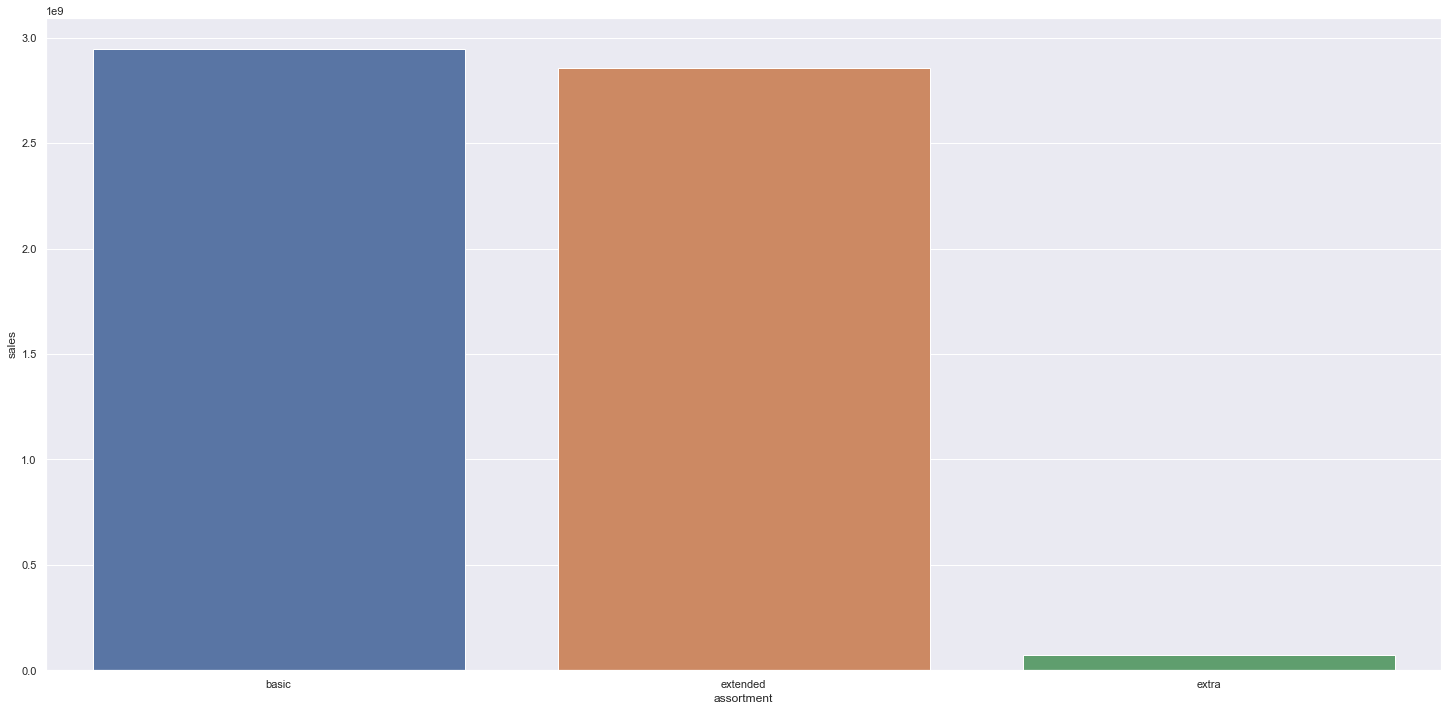

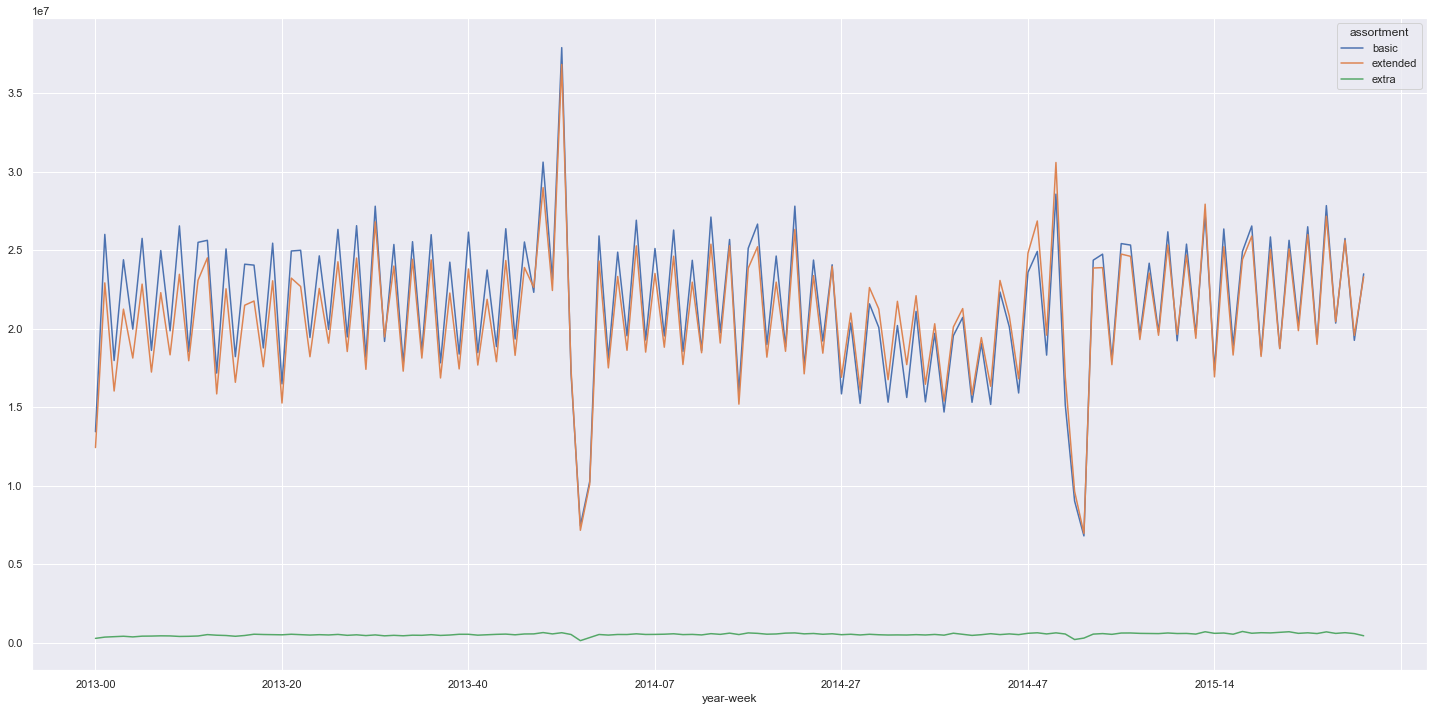

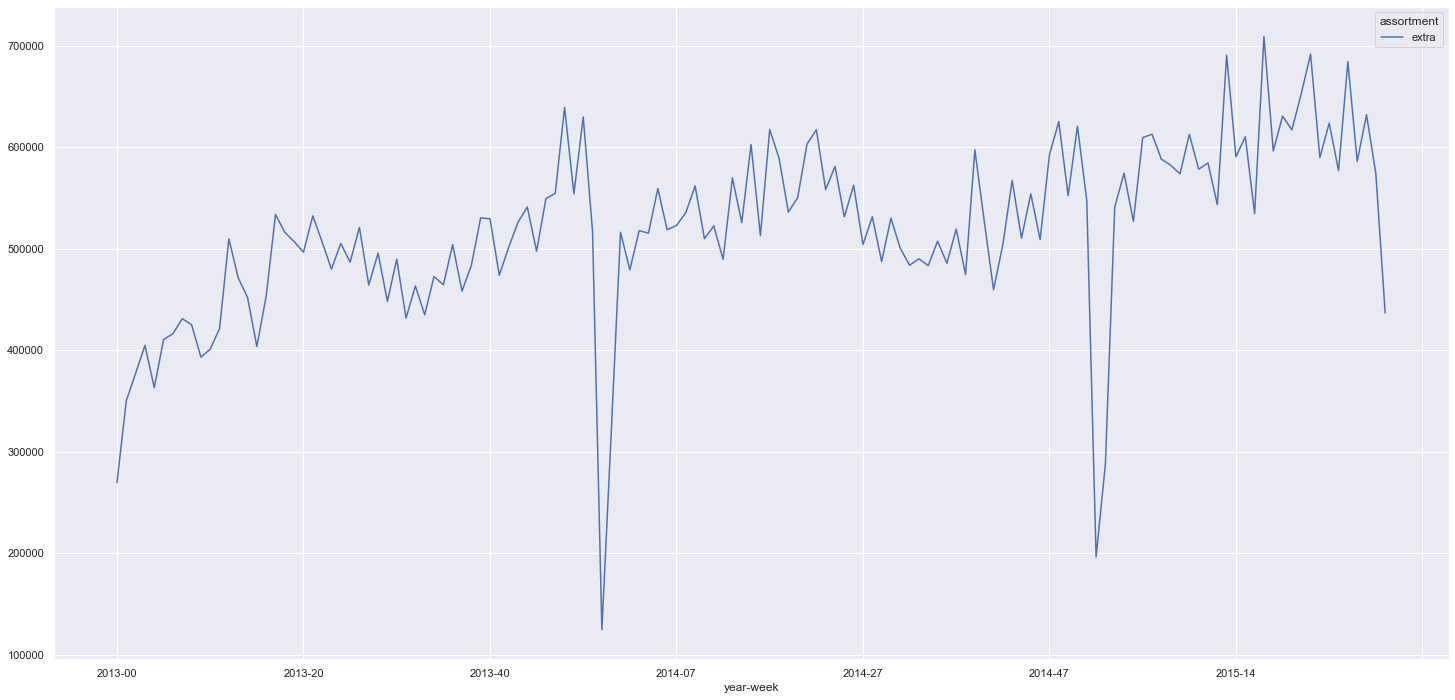

In [30]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year-week','assortment','sales']].groupby( ['year-week','assortment'] ).sum().reset_index()
aux2.pivot( index='year-week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year-week', columns='assortment', values='sales' ).plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES mais próximos vendem MAIS.

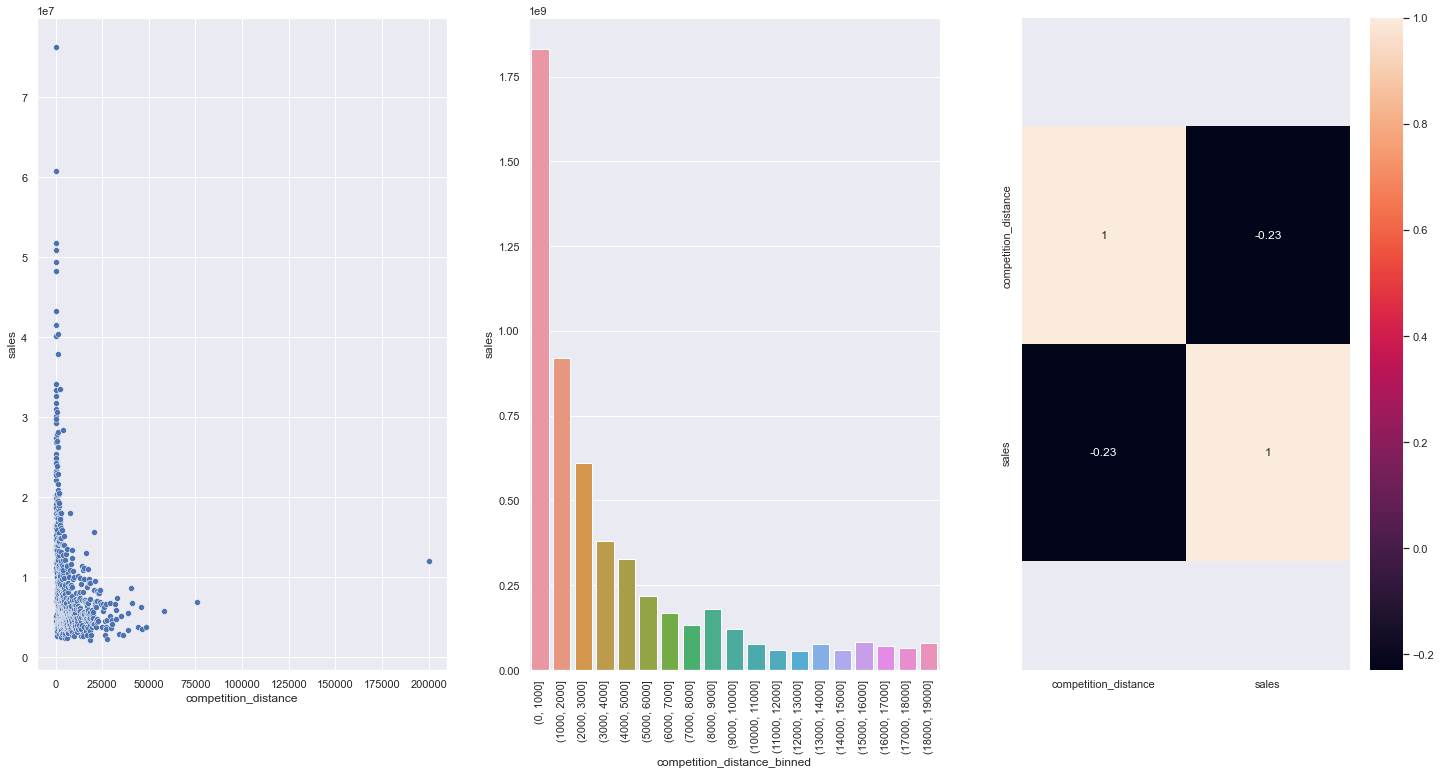

In [31]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins= list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned']= pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90 )

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** Lojas com COMPETIDORES à MAIS TEMPO, vendem MENOS.

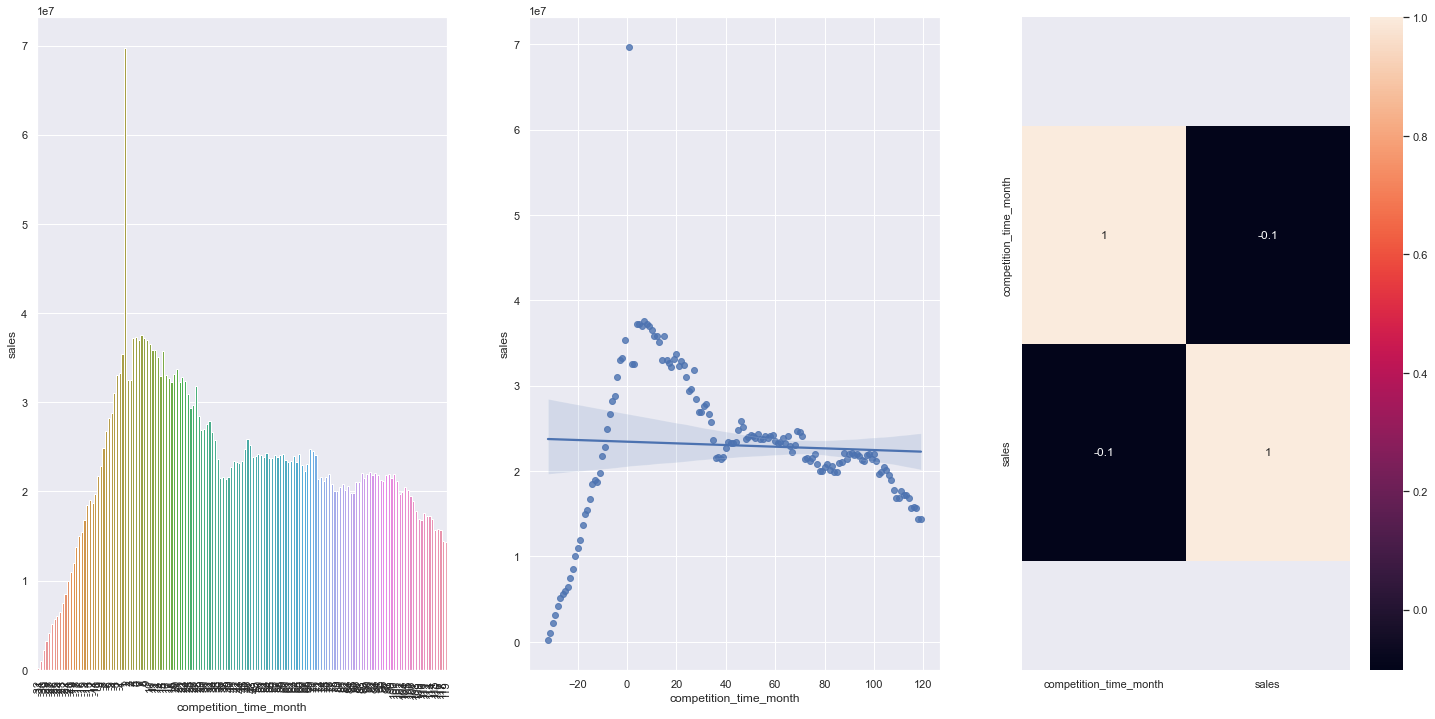

In [32]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com PROMOÇÕES ATIVAS POR MAIS TEMPO, VENDEM MENOS depois de um certo período de promoção.

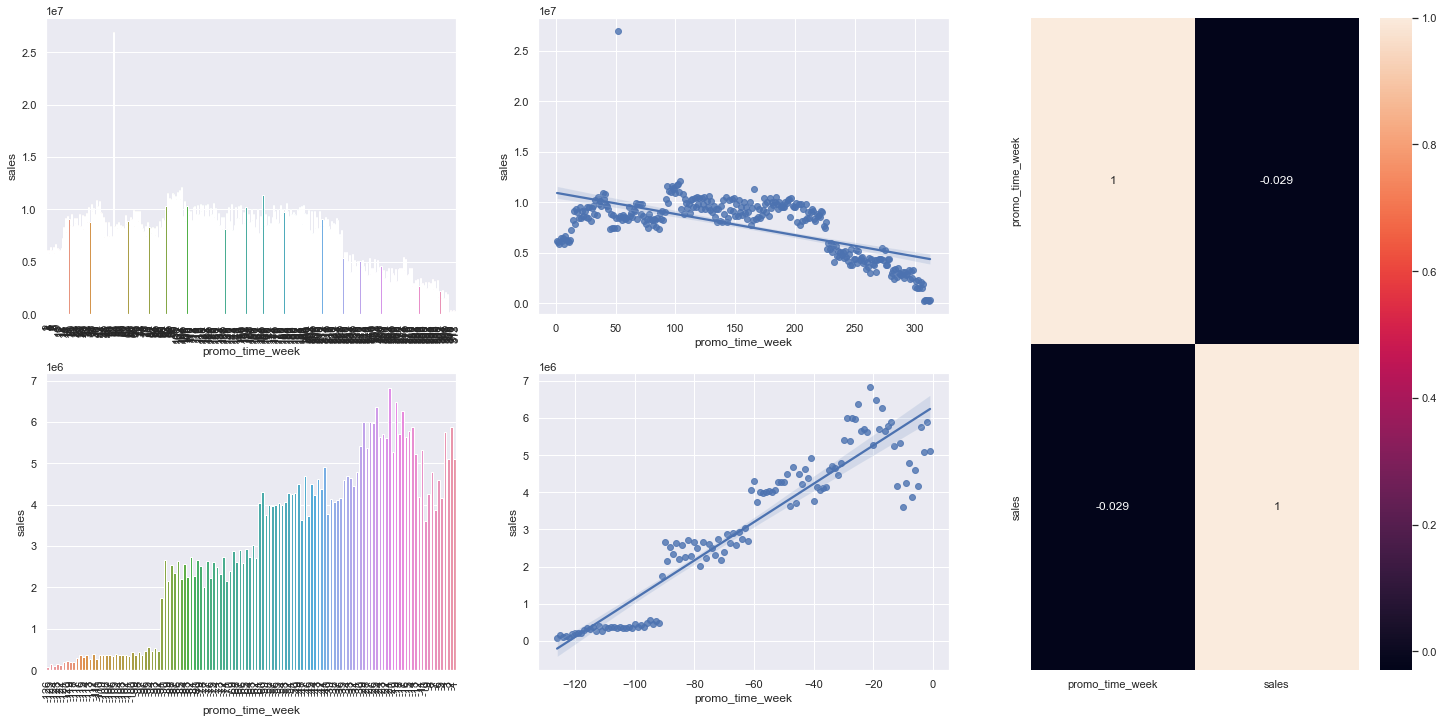

In [33]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo exetendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0, 1])
sns.regplot( x='promo_time_week', y='sales', data=aux2 );


plt.subplot( grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1, 1])
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[ :, 2])
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s> H5. Lojas com mais dias de promoção deveriam vender mais. <s/>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com PROMOÇÕES CONSECUTIVAS vendem MENOS.

In [34]:
df4[['promo', 'promo2','sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


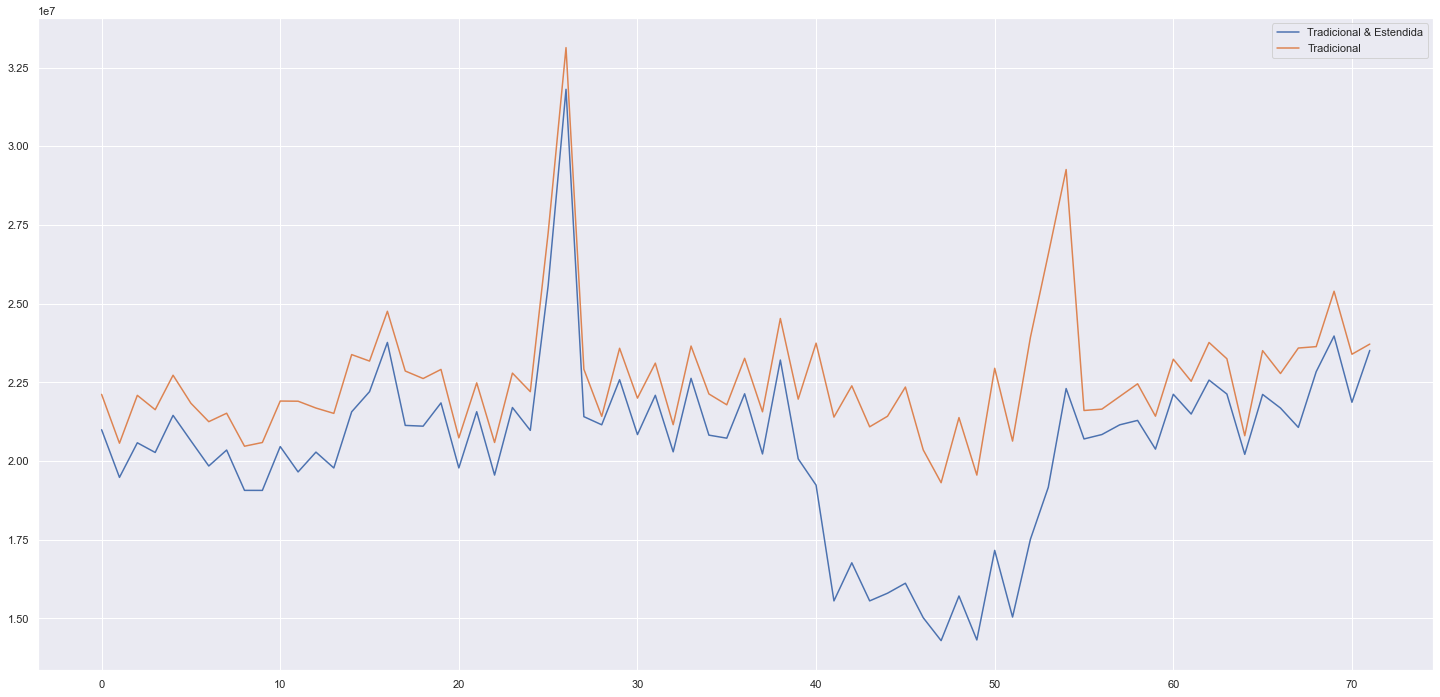

In [35]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1)][['year-week', 'sales']].groupby('year-week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0)][['year-week', 'sales']].groupby('year-week').sum().reset_index()
aux2.plot( ax=ax );

ax.legend( labels= ['Tradicional & Estendida', 'Tradicional'] );

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA -** No natal não vendemos mais que os outros feriados e nem menos que dias normais.

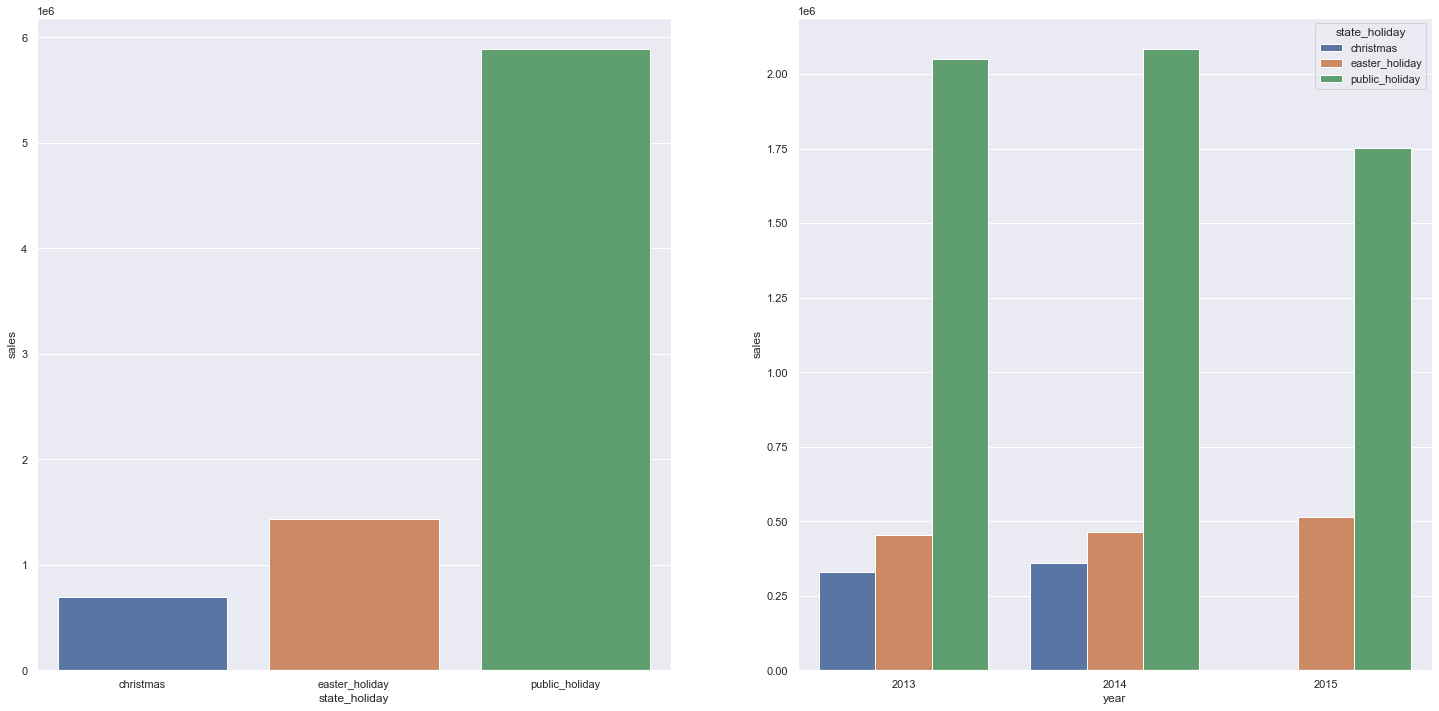

In [36]:
plt.subplot( 1, 2, 1 )
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot( 1, 2, 2 )
aux2 = aux[['year','state_holiday','sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA -** Lojas vendem ao longo dos anos.

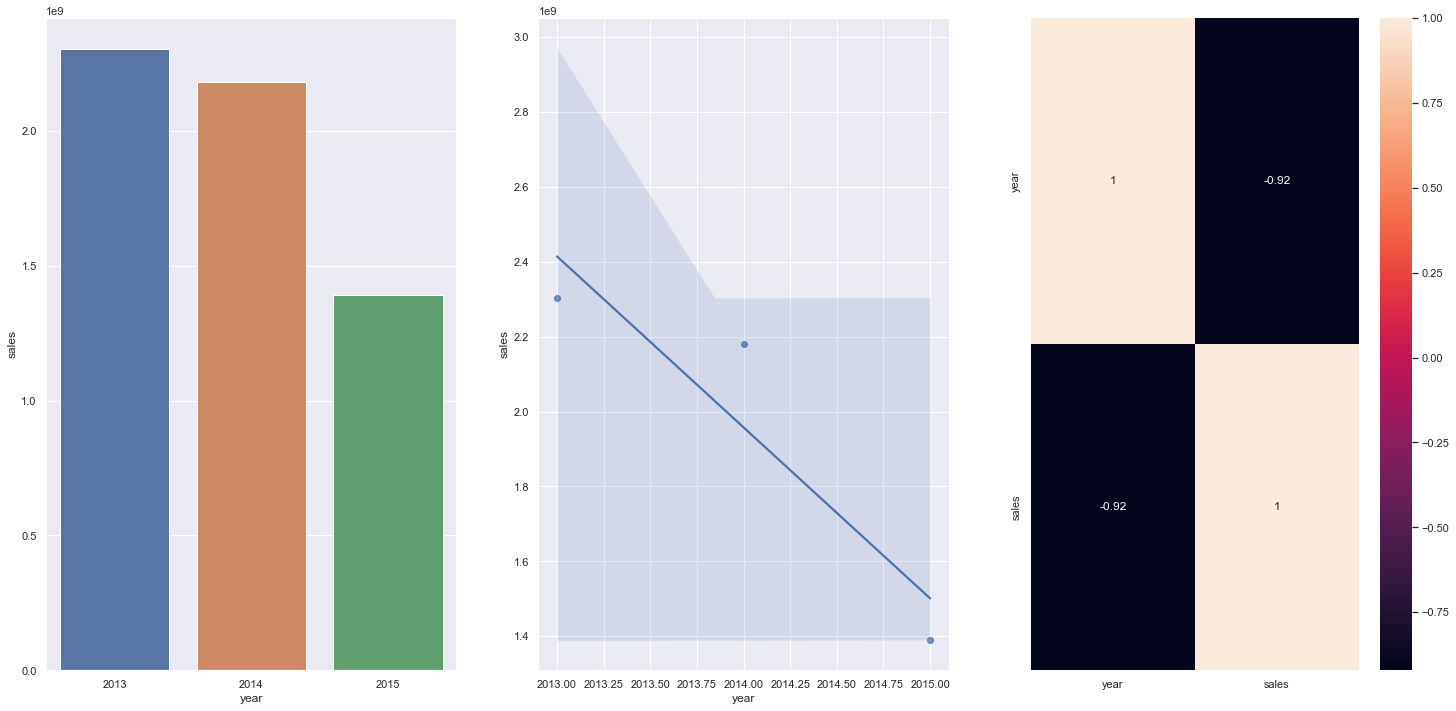

In [37]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**VERDADEIRA -** Se olharmos todo o conjunto de dados, podemos erroneamente afirmar que a hipótese é falsa, pois, o segundo semestre de 2015 não está completo, o que pode causar uma análise incorreta dos dados. Filtrando apenas pelos anos de 2013 e 2014, vemos que sim, o SEGUNDO SEMESTRE VENDE MAIS que o primeiro.

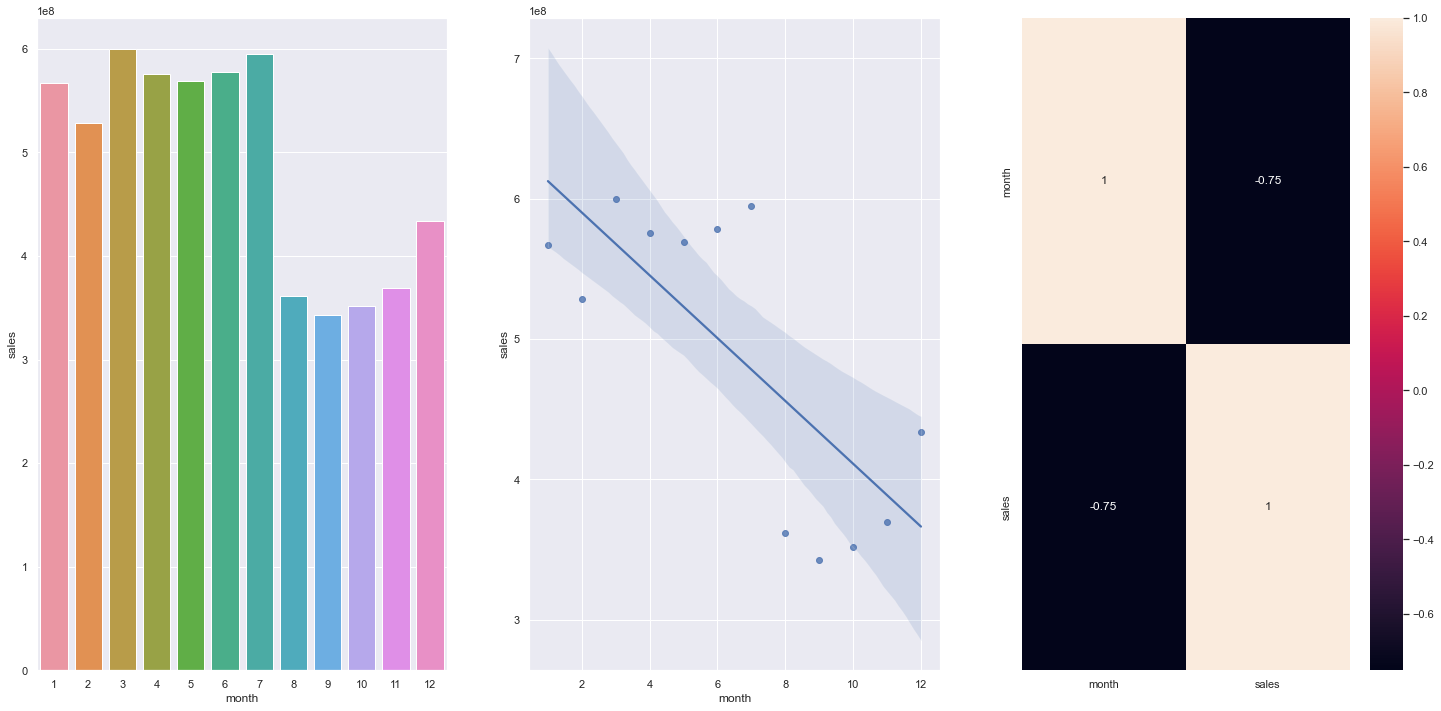

In [38]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

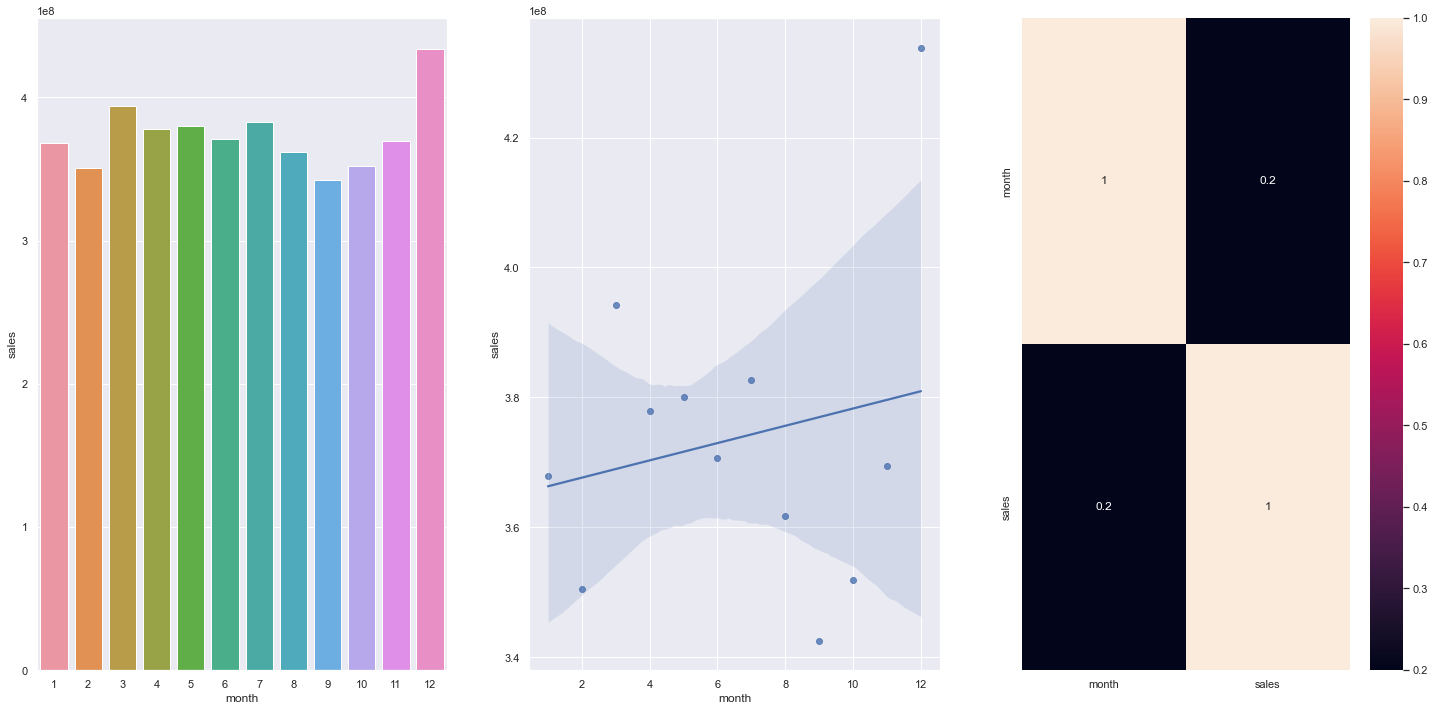

In [39]:
aux1 = df4.loc[df4['year'] != 2015]
aux1 = aux1[['month','sales']].groupby('month').sum().reset_index()


plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA -** Lojas VENDEM MAIS após o dia 10 de cada mês. Aproveitei para fazer também um comparativo entre as vendas em cada quinzena do mês e dos últimos 10 dias, o que comprovou que quando olhar por quinzena, temos um volume de vendas muito semelhante. Já olhando para a divisão antes e depois do vigésimo dia, temos um comportamento semelhante a comparação do décimo dia do mês, onde temos muito mais vendas antes do dia 20, o que nos leva a crer que temos esse comportamento porque temos o dobro de dias.

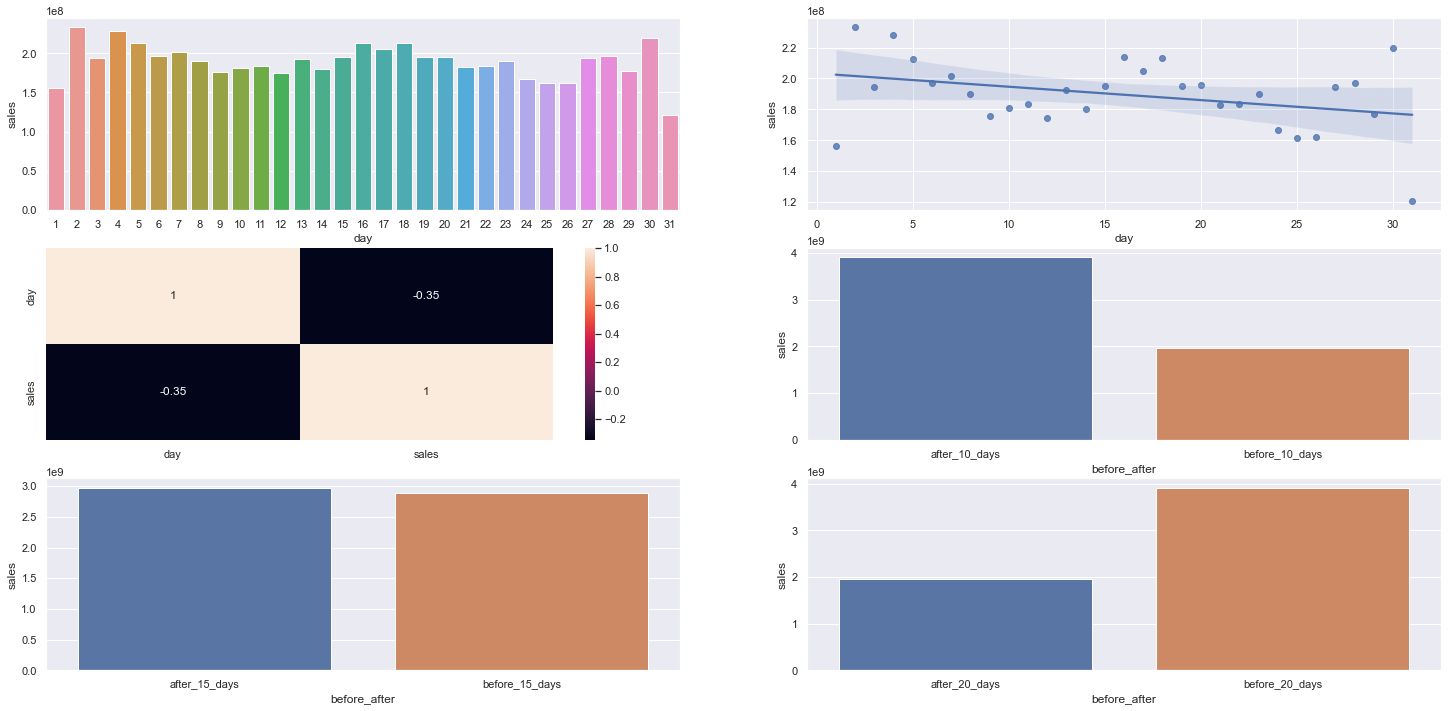

In [40]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot( 3, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 3, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 3, 2, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.subplot( 3, 2, 4 )
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );

plt.subplot( 3, 2, 5 )
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_15_days' if x <= 15 else 'after_15_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );

plt.subplot( 3, 2, 6 )
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_20_days' if x <= 20 else 'after_20_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA -** Lojas vendem menos aos finais de semana.

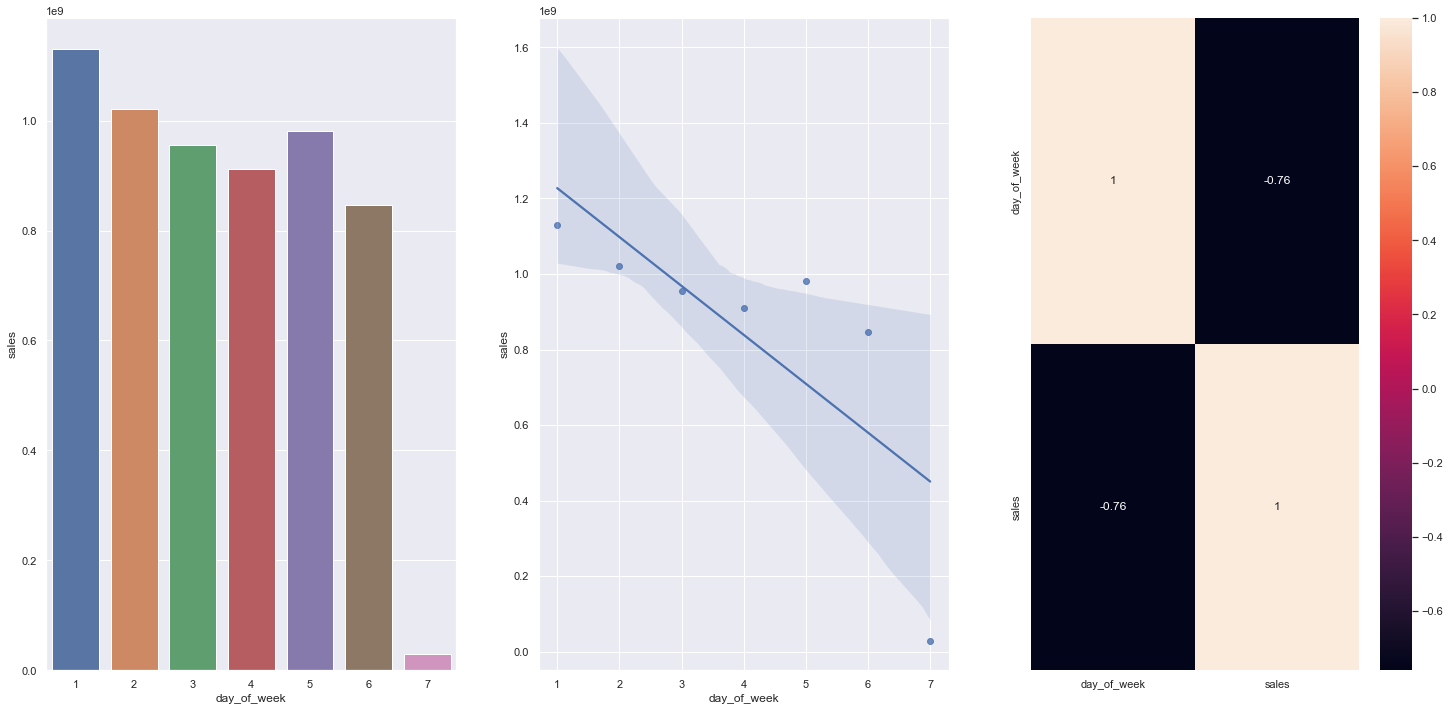

In [41]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA -** Lojas VENDEM MENOS nos feriados escolares, exceto nos meses de JULHO e AGOSTO onde as vendas começam a mudar o seu comportamento, sendo em julho a venda com volumes muito próximos e em agosto as vendas em feriados escolares são maiores. 

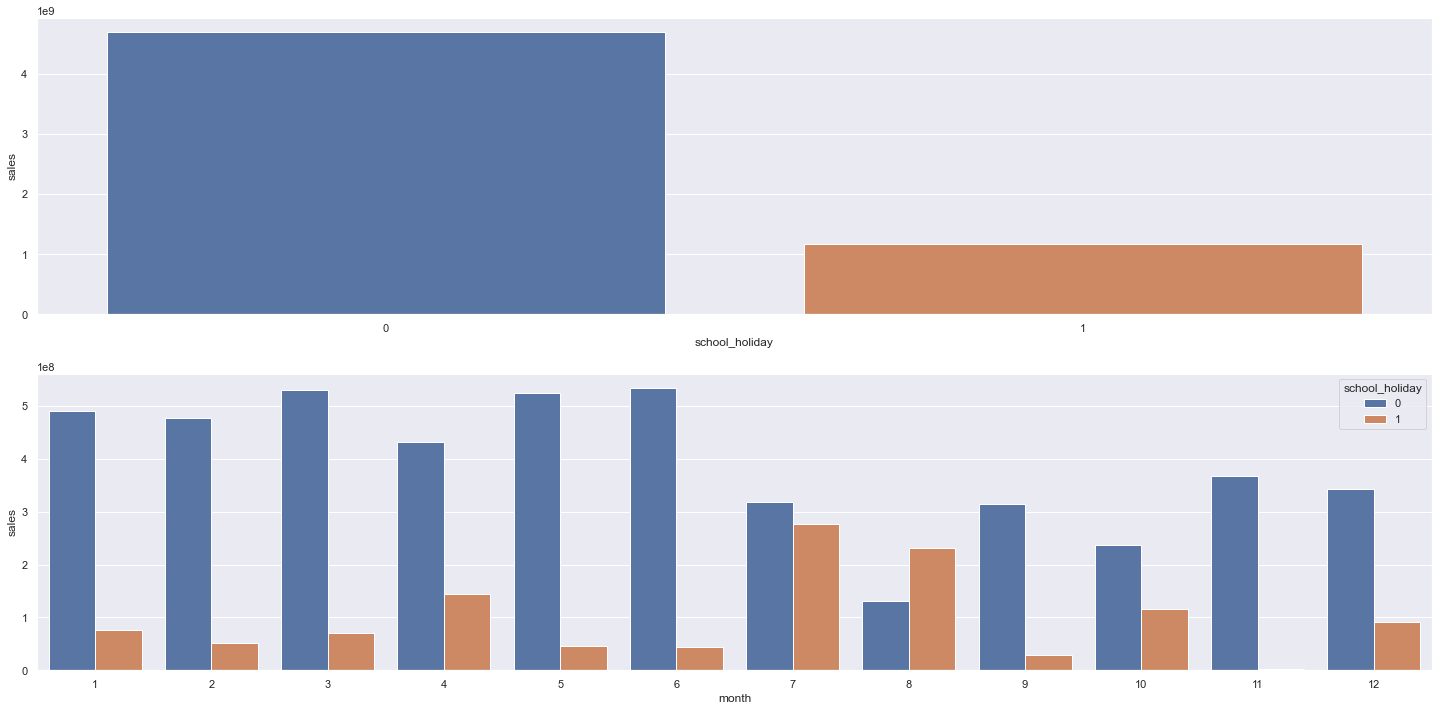

In [42]:
plt.subplot( 2, 1, 1 )
aux1 = df4[['school_holiday','sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux1 );

plt.subplot( 2, 1, 2 )
aux2 = df4[['month','school_holiday','sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday',data=aux2 );

## 4.2.1 Hypothesis Summary

In [43]:
table = [['Hipothesis','H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12'],
        ['Conclusion','False','False','False','False','-','False','False','False','True','True','True','True'],
        ['Relevance','Lower','Medium','Medium','Lower','-','Lower','Medium','Higher','Higher','Higher','Higher','Lower']]

print( tabulate(table, headers='firstrow', tablefmt='grid'))

+--------------+-------+--------+--------+-------+------+-------+--------+--------+--------+--------+--------+-------+
| Hipothesis   | H1    | H2     | H3     | H4    | H5   | H6    | H7     | H8     | H9     | H10    | H11    | H12   |
+==============+=======+========+========+=======+======+=======+========+========+========+========+========+=======+
| Conclusion   | False | False  | False  | False | -    | False | False  | False  | True   | True   | True   | True  |
+--------------+-------+--------+--------+-------+------+-------+--------+--------+--------+--------+--------+-------+
| Relevance    | Lower | Medium | Medium | Lower | -    | Lower | Medium | Higher | Higher | Higher | Higher | Lower |
+--------------+-------+--------+--------+-------+------+-------+--------+--------+--------+--------+--------+-------+


## 4.3. Multivariate Analysis

### 4.3.1 Numerical Attributes

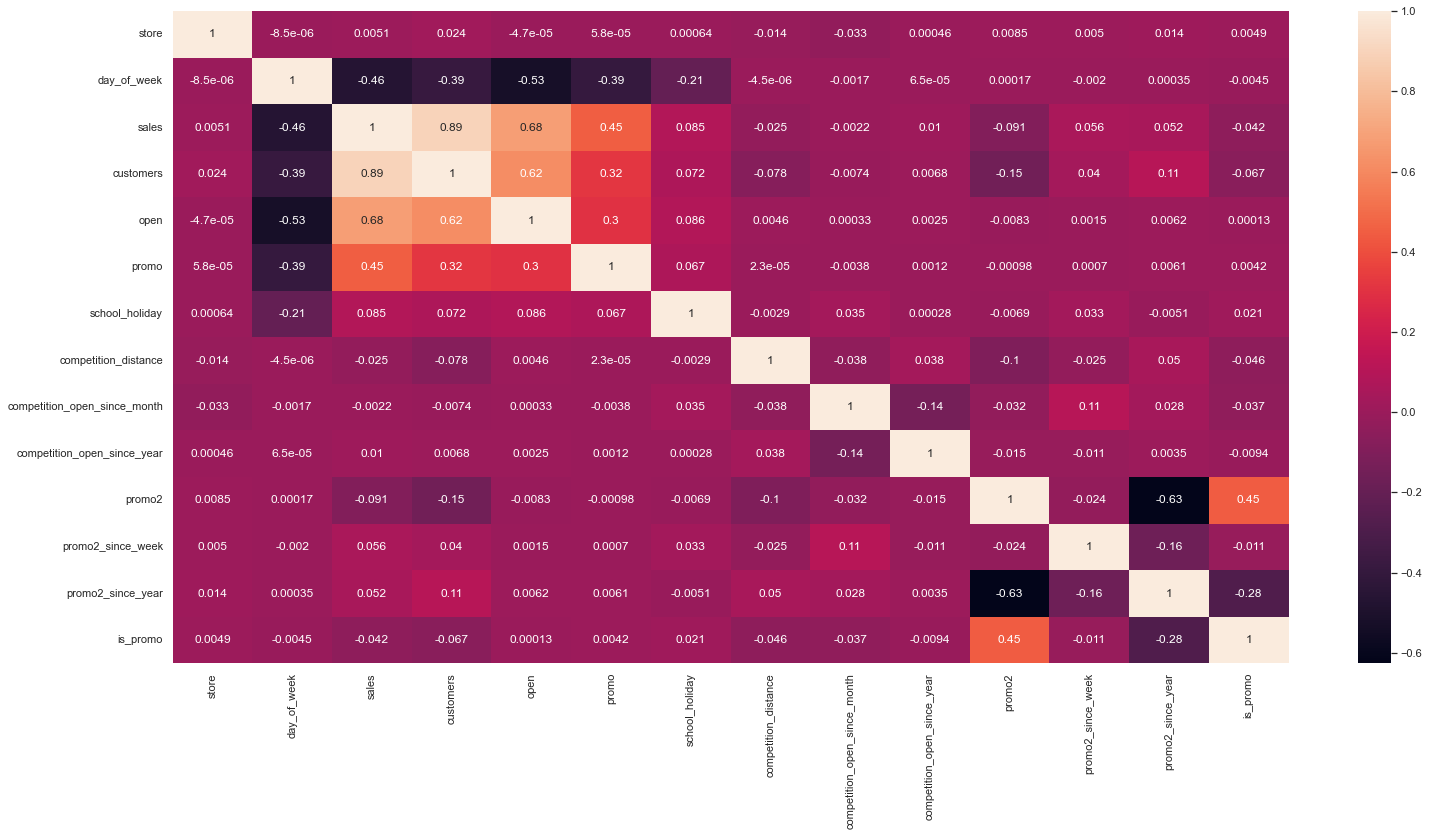

In [44]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap( correlation, annot=True);

### 4.3.2 Categorical Attributes

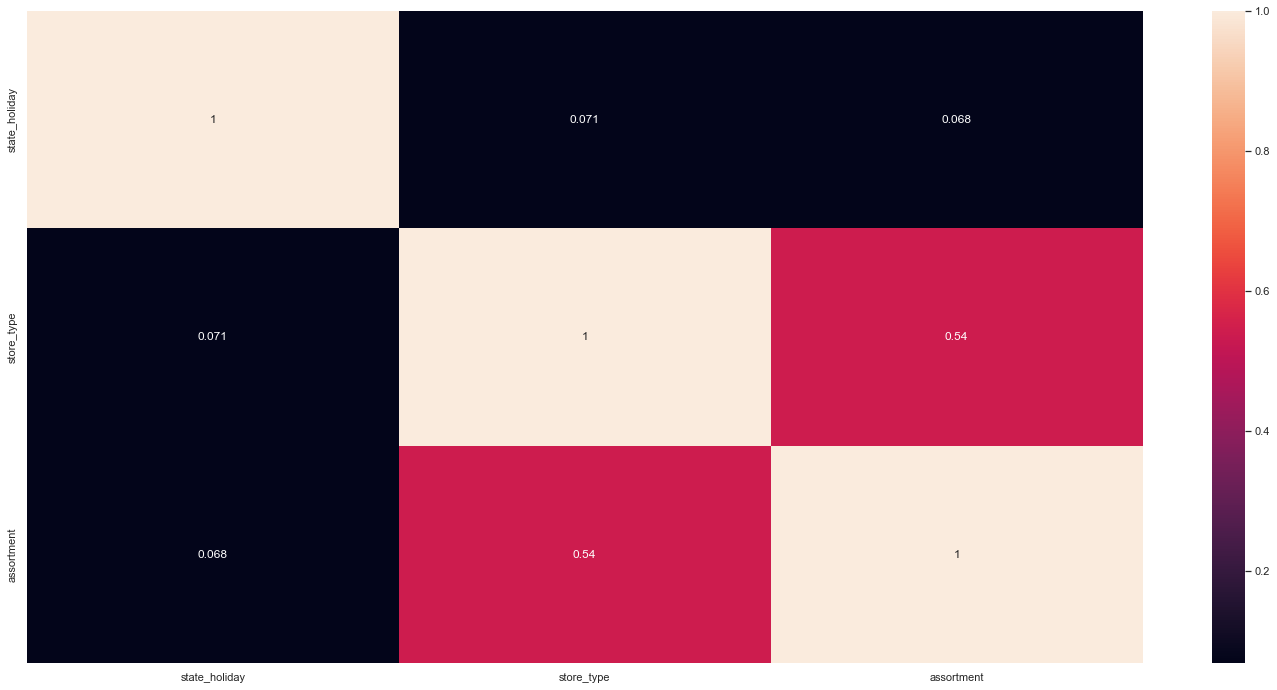

In [45]:
# filtering only categorical data
a = df4.select_dtypes( include='object')

# calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'] )
a2 = cramer_v(a['state_holiday'], a['store_type'] )
a3 = cramer_v(a['state_holiday'], a['assortment'] )

a4 = cramer_v(a['store_type'], a['state_holiday'] )
a5 = cramer_v(a['store_type'], a['store_type'] )
a6 = cramer_v(a['store_type'], a['assortment'] )

a7 = cramer_v(a['assortment'], a['state_holiday'] )
a8 = cramer_v(a['assortment'], a['store_type'] )
a9 = cramer_v(a['assortment'], a['assortment'] )

# final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6], 
               'assortment': [a7, a8, a9]
              })

d= d.set_index( d.columns )

sns.heatmap( d, annot=True);

# 5.0. PASSO 05 - DATA PREPARATION

In [50]:
df5 = df4.copy()

## 5.1. Normalization

Como não temos nenhuma distribuição normal nos nos dados baseado na análise bivariada feita na seção 4.1.2 Numerical Variable, optei por não forçar nenhuma normalização e deixar para fazer o rescaling das variáveis númericas.

## 5.2. Rescaling

In [51]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )


# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )


# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )


# year
df5['year'] = mms.fit_transform( df5[['year']].values )


## 5.3. Tranformation

### 5.3.1 Encoding

In [52]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding (por nao ter ordem)
le = LabelEncoder(  )
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding (temos uma ordem de grandeza dentro dos niveis)
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict)

### 5.3.2 Response Variable Transformation

In [53]:
df5['sales'] = np.log1p( df5['sales'] )

<AxesSubplot:xlabel='sales', ylabel='Density'>

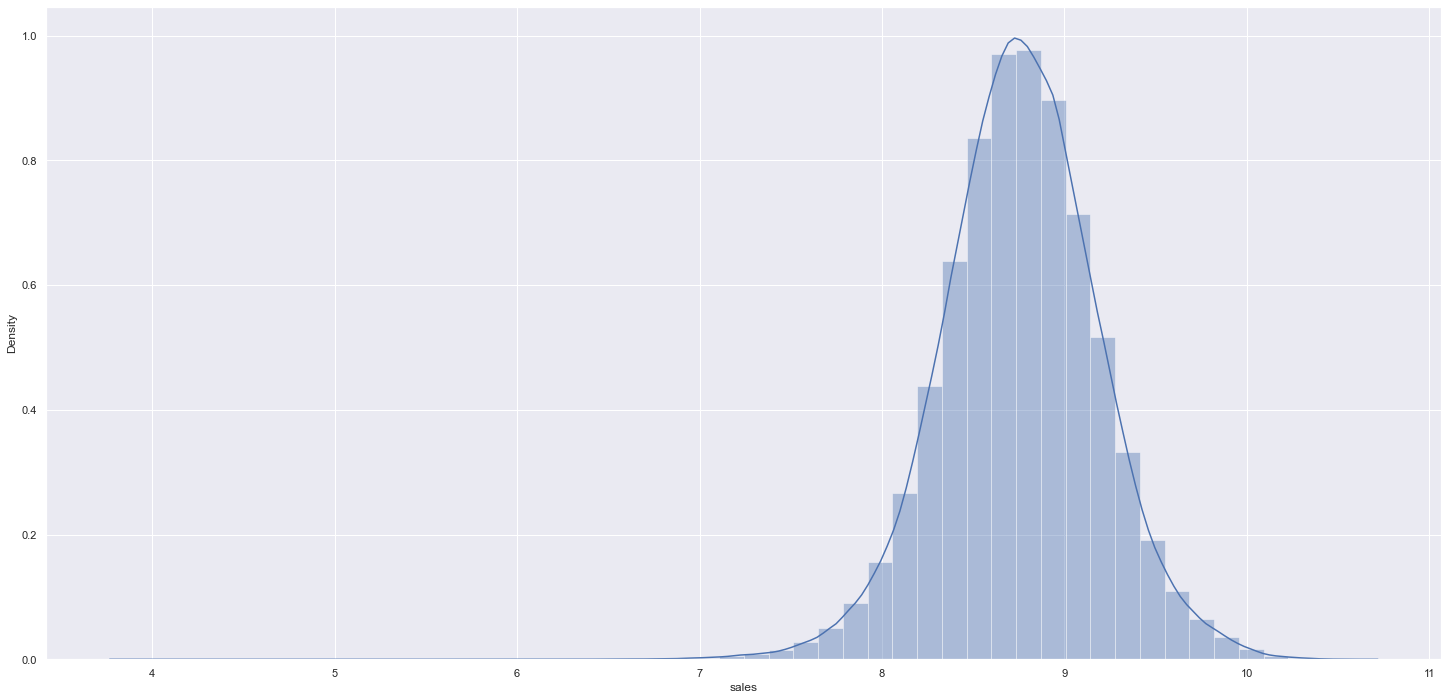

In [54]:
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [55]:
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

In [56]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year-week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_sin,day_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0. PASSO 06 - FEATURE SELECTION

In [57]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [58]:
cols_drop= ['week_of_year','day','month','day_of_week','competition_since','year-week','promo_since' ]
df6= df6.drop( cols_drop, axis=1)

In [59]:
df6[['store','date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7)

Timestamp('2015-06-19 00:00:00')

In [60]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test =  X_test['sales']

print( ' Training Min Date: {}'.format( X_train['date'].min() ) )
print( ' Training Min Date: {}'.format( X_train['date'].max() ) )

print( ' \nTest Min Date: {}'.format( X_test['date'].min() ) )
print( ' Test Min Date: {}'.format( X_test['date'].max() ) )

 Training Min Date: 2013-01-01 00:00:00
 Training Min Date: 2015-06-18 00:00:00
 
Test Min Date: 2015-06-19 00:00:00
 Test Min Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [61]:
# training and test dataset for Boruta
#x_train_n = x_train.drop( ['date','sales'],axis=1).values #converting the train dataset to array without column names
#y_train_n = y_train.values.ravel()


# define Random Forest Regressor
#rf = RandomForestRegressor( n_jobs=-1)

# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

## 6.2.1 Best Features from Boruta

In [62]:
#cols_selected = boruta.support_ # valor do rank de relevancia para cada feature

# best features
#x_train_fs = x_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [65]:
cols_selected_boruta = ['store',
                         'promo',
                         'store_type',
                         'assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'competition_time_month',
                         'promo_time_week',
                         'day_sin',
                         'day_cos',
                         'month_sin',
                         'month_cos',
                         'week_of_year_sin', 
                         'week_of_year_cos',
                         'day_of_week_sin',
                         'day_of_week_cos']

# columns to add 
feat_to_add = ['date','sales']

# final features 
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [66]:
df7 = df6.copy()

In [79]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [68]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns= {'sales':'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [69]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.2.1 Linear Regression Model - Cross Validation

In [70]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [71]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1891.704881,0.289106,2744.451739


## 7.3.1 Lasso - Cross Validation

In [72]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [73]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )
    
# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.841834,0.099844,1010.118629


## 7.4.1 Random Forest Regressor - Cross Validation

In [74]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2


KeyboardInterrupt: 

## 7.5. XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

## 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
xbg_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xbg_result_cv

## 7.6. Comparing Model's Performance

### 7.6.1 Single Performance

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

### 7.6.2 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xbg_result_cv] )
modelling_result.sort_values( 'RMSE' )

# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [75]:
param = { 
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9], 
    'min_child_weight': [3, 8, 15] }

max_eval = 5

In [82]:
final_result = pd.DataFrame()

for i in range( max_eval ):
    # choose values for parameters randomly
    hp = { k: random.sample( 1 )[0] for k, v in param.items() }
    print(hp)
    
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'])

    # performance
    result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )
    final_result = pd.concat( [final_resut, result])
    
final_result

{'n_estimators': 0.44411160487043655, 'eta': 0.46841887476936084, 'max_depth': 0.3590481531735593, 'subsample': 0.1008032812512687, 'colsample_bytree': 0.3374036088756093, 'min_child_weight': 0.44634947171241046}


TypeError: 'numpy.float64' object cannot be interpreted as an integer

## 8.2. Final Model

In [ ]:
param_tuned = { 
    'n_estimators': ,
    'eta': ,
    'max_depth': ,
    'subsample': ,
    'colsample_bytree': , 
    'min_child_weight':  }

max_eval = 2

In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight']).fit(xtrain, ytrain)
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )


# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned